In [1]:
import pandas as pd
import numpy as np
import time 


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import ShuffleSplit

In [2]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [3]:
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
train = train.drop(columns = ['device','interaction_type','command'])
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
test = test.drop(columns = ['device','interaction_type','command'])

In [4]:
x_train, y_train = train.drop(columns=['global_category']), train['global_category']
x_test, y_test = test.drop(columns=['global_category']), test['global_category']

# ADABOOST CLASSIFIER

In [5]:
ADB = AdaBoostClassifier()

#Número maximo de estimadores
n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num=10)]
#Algoritmo de boosting
algorithm = ['SAMME', 'SAMME.R']

In [17]:
start = time.time()
ADB.fit(x_train, y_train)
stop = time.time()

In [18]:
print(f"ADB time: {stop - start}s")
print(f'Train accuracy : {ADB.score(x_train, y_train): .3f}')
print(f'Test accuracy : {ADB.score(x_test, y_test): .3f}')

RandomizedSearch time: 9.806251525878906s
Train accuracy :  0.850
Test accuracy :  0.720


In [6]:
param_grid = {'n_estimators': n_estimators, 
              'algorithm': algorithm}

ADB_RandoGrid = RandomizedSearchCV(estimator = ADB, param_distributions = param_grid, 
                                   cv = 5, verbose=2, n_jobs = 4)

In [7]:
start = time.time()
ADB_RandoGrid.fit(x_train, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [8]:
print(f"RandomizedSearch time: {stop - start}s")
print(f'Train accuracy : {ADB_RandoGrid.score(x_train, y_train): .3f}')
print(f'Test accuracy : {ADB_RandoGrid.score(x_test, y_test): .3f}')

RandomizedSearch time: 217.51408290863037s
Train accuracy :  0.963
Test accuracy :  0.748


In [9]:
ADB_RandoGrid.best_params_

{'n_estimators': 157, 'algorithm': 'SAMME'}

In [19]:
#Probamos los mejores parámetros
ADB = AdaBoostClassifier(n_estimators = 157,
                         algorithm='SAMME')


start = time.time()
ADB.fit(x_train, y_train)
stop = time.time()

In [20]:
print(f"AdaBoost training time: {stop - start}s")
print(f'Train accuracy : {ADB.score(x_train, y_train): .3f}')
print(f'Test accuracy : {ADB.score(x_test, y_test): .3f}')

AdaBoost training time: 29.94755983352661s
Train accuracy :  0.963
Test accuracy :  0.748


## Matriz de confusión:

In [14]:
#Guardamos la predicción de Adaboost
y_pred_ADB = ADB.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_ADB)

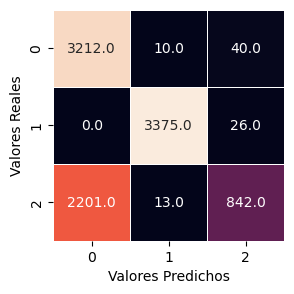

In [15]:
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot = True, fmt = '0.1f', linewidth=0.5, 
            square = True, cbar = False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [17]:
print(metrics.classification_report(y_test, y_pred_ADB))

                 precision    recall  f1-score   support

          AUDIO       0.59      0.98      0.74      3262
         CAMERA       0.99      0.99      0.99      3401
HOME AUTOMATION       0.93      0.28      0.42      3056

       accuracy                           0.76      9719
      macro avg       0.84      0.75      0.72      9719
   weighted avg       0.84      0.76      0.73      9719



## Introduciendo parámetros manualmente:

In [21]:
ADB = AdaBoostClassifier(n_estimators = 24,
                         algorithm='SAMME')


#24 -> 0.788
start = time.time()
ADB.fit(x_train, y_train)
stop = time.time()

In [22]:
print(f"AdaBoost training time: {stop - start}s")
print(f'Train accuracy : {ADB.score(x_train, y_train): .3f}')
print(f'Test accuracy : {ADB.score(x_test, y_test): .3f}')

AdaBoost training time: 4.625969648361206s
Train accuracy :  0.964
Test accuracy :  0.788


## Matriz de confusión:

In [28]:
#Guardamos la predicción de Adaboost
y_pred_ADB2 = ADB.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_ADB2)

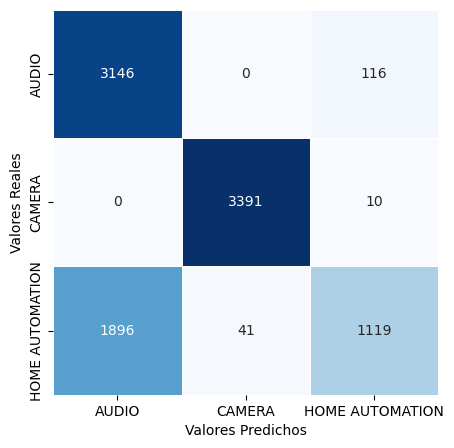

In [29]:
class_names = ['AUDIO', 'CAMERA', 'HOME AUTOMATION']

sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [31]:
print(metrics.classification_report(y_test, y_pred_ADB2))

                 precision    recall  f1-score   support

          AUDIO       0.62      0.96      0.76      3262
         CAMERA       0.99      1.00      0.99      3401
HOME AUTOMATION       0.90      0.37      0.52      3056

       accuracy                           0.79      9719
      macro avg       0.84      0.78      0.76      9719
   weighted avg       0.84      0.79      0.77      9719



# LGBM:

## Sin hiperparámetros:

In [10]:
LGBM = LGBMClassifier()

start = time.time()
LGBM.fit(x_train, y_train)
stop = time.time()

In [11]:
print(f"LGBM time: {stop - start}s")
print(f'Train accuracy : {LGBM.score(x_train, y_train): .3f}')
print(f'Test accuracy : {LGBM.score(x_test, y_test): .3f}')

LGBM time: 1.0483415126800537s
Train accuracy :  1.000
Test accuracy :  0.801


## Introduciendo hiperparámetros:

In [12]:
boosting_type = ['gbdt', 'dart', 'rf']
#Máx. número de hojas para los 'base learners'
num_leaves = [int(x) for x in np.linspace(start=1, stop=50, num=50)]
#Número de 'boosted trees'
n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num=20)]
#Mínimo número de datos que se necesitan en las hojas

In [13]:
param_grid7 = {'boosting_type': boosting_type, 
              'num_leaves': num_leaves,
              'n_estimators': n_estimators}

LGBM_RandomGrid = RandomizedSearchCV(estimator = LGBM,
                                    param_distributions = param_grid7, 
                                    cv = 5, verbose=2)

start = time.time()
LGBM_RandomGrid.fit(x_train, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .boosting_type=dart, n_estimators=50, num_leaves=45; total time=   0.5s
[CV] END .boosting_type=dart, n_estimators=50, num_leaves=45; total time=   0.4s
[CV] END .boosting_type=dart, n_estimators=50, num_leaves=45; total time=   0.4s
[CV] END .boosting_type=dart, n_estimators=50, num_leaves=45; total time=   0.4s
[CV] END .boosting_type=dart, n_estimators=50, num_leaves=45; total time=   0.5s
[CV] END boosting_type=gbdt, n_estimators=180, num_leaves=18; total time=   0.7s
[CV] END boosting_type=gbdt, n_estimators=180, num_leaves=18; total time=   0.8s
[CV] END boosting_type=gbdt, n_estimators=180, num_leaves=18; total time=   0.8s
[CV] END boosting_type=gbdt, n_estimators=180, num_leaves=18; total time=   0.8s
[CV] END boosting_type=gbdt, n_estimators=180, num_leaves=18; total time=   0.8s
[CV] END boosting_type=gbdt, n_estimators=190, num_leaves=50; total time=   1.1s
[CV] END boosting_type=gbdt, n_estimators=190, n


10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\boii_\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\boii_\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\boii_\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\boii_\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster

In [15]:
print('Score: ', LGBM_RandomGrid.best_score_)
print('Parameters: ', LGBM_RandomGrid.best_params_)

Score:  0.9691039679736253
Parameters:  {'num_leaves': 50, 'n_estimators': 190, 'boosting_type': 'gbdt'}


In [16]:
print(f"LGBM_RandomGrid training time: {stop - start}s")
print(f'Train accuracy : {LGBM_RandomGrid.score(x_train, y_train): .3f}')
print(f'Test accuracy : {LGBM_RandomGrid.score(x_test, y_test): .3f}')

LGBM_RandomGrid training time: 28.74384331703186s
Train accuracy :  1.000
Test accuracy :  0.807


In [23]:
LGBM2 = LGBMClassifier(num_leaves = 50,
                      n_estimators = 190, 
                      boosting_type = 'gbdt')
#28
#4 -> 0.829
start = time.time()
LGBM2.fit(x_train, y_train)
stop = time.time()

In [24]:
print(f"LGBM time: {stop - start}s")
print(f'Train accuracy : {LGBM2.score(x_train, y_train): .3f}')
print(f'Test accuracy : {LGBM2.score(x_test, y_test): .3f}')

LGBM time: 1.263223648071289s
Train accuracy :  1.000
Test accuracy :  0.807


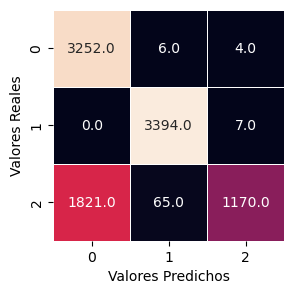

In [281]:
#Guardamos la predicción de MLP
y_pred_LGBM2 = LGBM2.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_LGBM2)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot = True, fmt = '0.1f', linewidth=0.5, 
            square = True, cbar = False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [282]:
print("Reporte del clasificador MLP: \n %s\n %s\n"
     %(LGBM, metrics.classification_report(y_test, y_pred_LGBM2)))

Reporte del clasificador MLP: 
 LGBMClassifier(n_estimators=170, num_leaves=40)
                  precision    recall  f1-score   support

          AUDIO       0.64      1.00      0.78      3262
         CAMERA       0.98      1.00      0.99      3401
HOME AUTOMATION       0.99      0.38      0.55      3056

       accuracy                           0.80      9719
      macro avg       0.87      0.79      0.77      9719
   weighted avg       0.87      0.80      0.78      9719




## Introducimos los parámetros de forma manual:

In [25]:
LGBM3 = LGBMClassifier(num_leaves = 28,
                      n_estimators = 4, 
                      boosting_type = 'gbdt')
#28
#4 -> 0.829
start = time.time()
LGBM3.fit(x_train, y_train)
stop = time.time()

In [26]:
print(f"LGBM time: {stop - start}s")
print(f'Train accuracy : {LGBM3.score(x_train, y_train): .3f}')
print(f'Test accuracy : {LGBM3.score(x_test, y_test): .3f}')

LGBM time: 0.17575788497924805s
Train accuracy :  0.998
Test accuracy :  0.831


## Matriz de confusión:

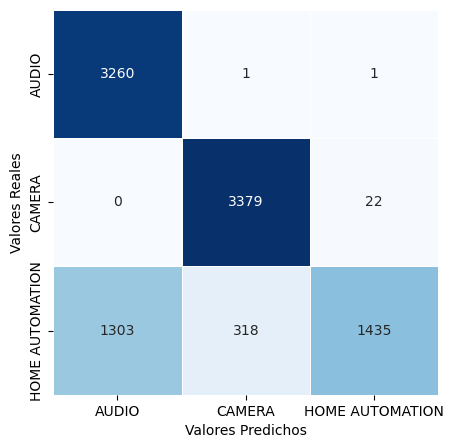

In [27]:
y_pred_LGBM3 = LGBM3.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_LGBM3)

class_names = ['AUDIO', 'CAMERA', 'HOME AUTOMATION']

sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [288]:
print("Reporte del clasificador MLP: \n %s\n %s\n"
     %(LGBM, metrics.classification_report(y_test, y_pred_LGBM2)))

Reporte del clasificador MLP: 
 LGBMClassifier()
                  precision    recall  f1-score   support

          AUDIO       0.64      1.00      0.78      3262
         CAMERA       0.98      1.00      0.99      3401
HOME AUTOMATION       0.99      0.38      0.55      3056

       accuracy                           0.80      9719
      macro avg       0.87      0.79      0.77      9719
   weighted avg       0.87      0.80      0.78      9719


